# Chapter 7 Applied Exercises

## Problem 6

### In this exercise, you will further analyze the Wage data set considered throughout this chapter.

In [2]:
import numpy as np, pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (summarize,
                         poly,
                         ModelSpec as MS)
from statsmodels.stats.anova import anova_lm

In [3]:
from pygam import (s as s_gam,
                   l as l_gam,
                   f as f_gam,
                   LinearGAM,
                   LogisticGAM)

from ISLP.transforms import (BSpline,
                             NaturalSpline)
from ISLP.models import bs, ns
from ISLP.pygam import (approx_lam,
                        degrees_of_freedom,
                        plot as plot_gam,
                        anova as anova_gam)

#### Part (a)

Perform polynomial regression to predict wage using age. Use cross-validation to select the optimal degree d for the polynomial. What degree was chosen, and how does this compare to
the results of hypothesis testing using ANOVA? Make a plot of the resulting polynomial fit to the data.

In [4]:
Wage = load_data('Wage')
y = Wage['wage']
age = Wage['age']

In [5]:
import sklearn.model_selection as skm

In [6]:
poly_age = MS([poly('age', degree=4)]).fit(Wage)
M = sm.OLS(y, poly_age.transform(Wage)).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,111.7036,0.729,153.283,0.000
"poly(age, degree=4)[0]",447.0679,39.915,11.201,0.000
"poly(age, degree=4)[1]",-478.3158,39.915,-11.983,0.000
"poly(age, degree=4)[2]",125.5217,39.915,3.145,0.002
"poly(age, degree=4)[3]",-77.9112,39.915,-1.952,0.051


In [7]:
from sklearn.model_selection import cross_validate, KFold

In [8]:
from ISLP.models import sklearn_sm

In [9]:
cv_error = np.zeros(6)
H = np.array(age)
M = sklearn_sm(sm.OLS)
#Let's introduce splits. We choose 5-folds cross validation for this example
cv = KFold(n_splits=5,shuffle=True,random_state=0) # The argument shuffle allows samples to overlap
for i, d in enumerate(range(1,7)):
    Xcross = np.power.outer(H, np.arange(d+1))
    M_CV = cross_validate(M,Xcross,y,cv=cv)
    cv_error[i] = np.mean(M_CV['test_score'])
cv_error

array([1675.97797787, 1600.6843786 , 1597.00855538, 1596.20945876,
       1598.21530779, 1597.23739361])

4th Degree Polynomial

In [10]:
model = sm.OLS(y,np.power.outer(H, np.arange(5))).fit()

In [11]:
Xcross = np.power.outer(H, np.arange(5))

In [12]:
# newX = poly_age.transform(age_df)
preds = model.get_prediction(Xcross)
#bands = preds.conf_int(alpha=0.05)

In [13]:
preds.predicted_mean

array([ 51.93145032,  84.47675567, 119.32598488, ...,  95.44973384,
        95.44973384, 118.6326942 ])

Text(0, 0.5, 'Wage')

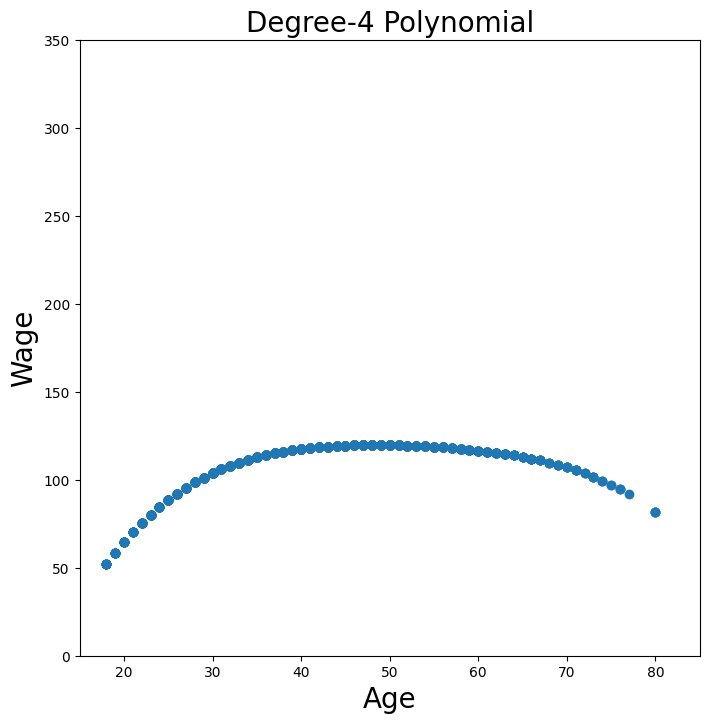

In [14]:
fig, ax = subplots(figsize=(8,8))
rng = np.random.default_rng(0)
ax.scatter(age, preds.predicted_mean)
ax.set_title('Degree-4 Polynomial', fontsize=20)
ax.set_xlabel('Age', fontsize=20)
ax.set_ylim([0,350])
ax.set_xlim([15,85])
ax.set_ylabel('Wage', fontsize=20)

Decided on the same degree as with ANOVA.

#### Part (b)

Fit a step function to predict wage using age, and perform cross-validation to choose the optimal number of cuts. Make a plot of the fit obtained.

In [15]:
cut_age = pd.qcut(age, 4)
summarize(sm.OLS(y, pd.get_dummies(cut_age)).fit())

,coef,std err,t,P>|t|
"(17.999, 33.75]",94.1584,1.478,63.692,0.0
"(33.75, 42.0]",116.6608,1.470,79.385,0.0
"(42.0, 51.0]",119.1887,1.416,84.147,0.0
"(51.0, 80.0]",116.5717,1.559,74.751,0.0


In [16]:
cv_error = np.zeros(30)
H = np.array(age)
M = sklearn_sm(sm.OLS)
#Let's introduce splits. We choose 5-folds cross validation for this example
cv = KFold(n_splits=5,shuffle=True,random_state=0) # The argument shuffle allows samples to overlap
for d in range(0,30):
    Xcross = pd.qcut(age, d+1)
    M_CV = cross_validate(M,pd.get_dummies(Xcross),y,cv=cv)
    cv_error[d] = np.mean(M_CV['test_score'])
cv_error

array([1742.94424898, 1703.98624771, 1660.21747041, 1643.54893817,
       1641.65415209, 1636.90408532, 1627.35473711, 1624.53060805,
       1625.31470466, 1619.42520284, 1622.99428956, 1622.98944769,
       1616.50042257, 1613.99483953, 1617.08432164, 1617.62667623,
       1620.03577132, 1618.02476215, 1617.60926168, 1618.28838019,
       1618.78656934, 1618.66520555, 1615.71065115, 1615.08454302,
       1623.61393177, 1622.5769718 , 1617.18053982, 1619.97063009,
       1612.53017386, 1613.04645163])

Choose 10 cuts for the best CV error. The CV error stops decreasing significantly after 10 cuts.

In [17]:
cut_age = pd.qcut(age, 10)
tencuts = summarize(sm.OLS(y, pd.get_dummies(cut_age)).fit())
tencuts

,coef,std err,t,P>|t|
"(17.999, 27.0]",82.2511,2.205,37.297,0.0
"(27.0, 32.0]",102.3635,2.202,46.487,0.0
"(32.0, 35.0]",110.0889,2.601,42.330,0.0
"(35.0, 39.0]",119.1562,2.261,52.710,0.0
"(39.0, 42.0]",116.7891,2.344,49.826,0.0
"(42.0, 46.0]",121.6993,2.097,58.030,0.0
"(46.0, 49.0]",117.8501,2.424,48.621,0.0
"(49.0, 53.0]",115.7022,2.286,50.610,0.0
"(53.0, 58.0]",117.8944,2.340,50.383,0.0
"(58.0, 80.0]",115.7284,2.543,45.516,0.0


In [18]:
xr = np.zeros(10)
for i in range(0,10):
    string1=tencuts.index[i]
    substring = string1[-5:]
    substring = substring[:-1]
    xr[i] = float(substring)
xr

array([27., 32., 35., 39., 42., 46., 49., 53., 58., 80.])

In [19]:
xl = np.zeros(11)
for i in range(0,10):
    string1=tencuts.index[i]
    substring = string1[:-7]
    substring = substring[1:]
    xl[i] = float(substring)
xl[10]=xr[9]

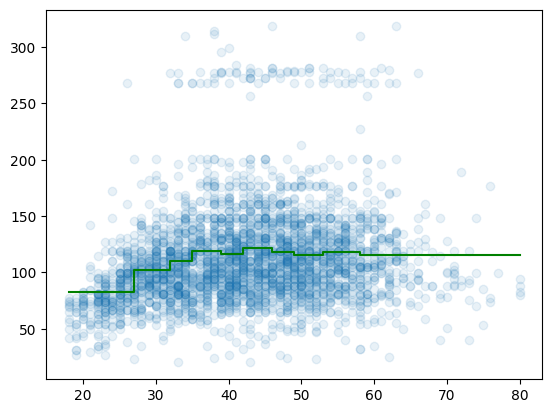

In [20]:
import matplotlib.pyplot as plt
import numpy as np
  
xr = np.zeros(10)
for i in range(0,10):
    string1=tencuts.index[i]
    substring = string1[-5:]
    substring = substring[:-1]
    xr[i] = float(substring)
y_step = np.zeros(11)
for i in range(0,10):
    y_step[i]=tencuts.coef[i]
y_step[10]=tencuts.coef[9]
  
plt.step(xl, y_step, 'g', where='post')
plt.scatter(age,y,alpha=0.1)
plt.show()

## Problem 7

The Wage data set contains a number of other features not explored in this chapter, such as marital status (maritl), job class (jobclass), and others. Explore the relationships between some of these other predictors and wage, and use non-linear fitting techniques in order to fit flexible models to the data. Create plots of the results obtained, and write a summary of your findings.

In [21]:
Wage

,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,2003,43,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,2005,50,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154
...,...,...,...,...,...,...,...,...,...,...,...
2995,2008,44,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,2. >=Very Good,1. Yes,5.041393,154.685293
2996,2007,30,2. Married,1. White,2. HS Grad,2. Middle Atlantic,1. Industrial,2. >=Very Good,2. No,4.602060,99.689464
2997,2005,27,2. Married,2. Black,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.193125,66.229408
2998,2005,27,1. Never Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,2. >=Very Good,1. Yes,4.477121,87.981033


In [22]:
y = Wage['wage']
age = Wage['age']
maritl = Wage['maritl']
jobclass = Wage['jobclass']
year = Wage['year']

In [23]:
X = pd.get_dummies(Wage['maritl']).values
gam_bh = sm.OLS(y, X).fit()

In [24]:
gam_bh.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   wage   R-squared:                       0.070
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     55.96
Date:                Sat, 10 May 2025   Prob (F-statistic):           1.40e-45
Time:                        10:18:47   Log-Likelihood:                -15342.
No. Observations:                3000   AIC:                         3.069e+04
Df Residuals:                    2995   BIC:                         3.072e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            92.7346      1.582     58.608      0.000      89.632      95.837
x2           118.8603      0.884    134.391      0.000     117.126     120.594
x3            99.5387      9.241     10.772      0.000      81.420     117.657
x4           103.1593      2.820     36.581      0.000      97.630     108.689
x5           101.2158      5.431     18.636      0.000      90.567     111.865
==============================================================================
Omnibus:                     1092.638   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4899.270
Skew:                           1.716   Prob(JB):                         0.00
Kurtosis:                       8.236   Cond. No.                         10.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [25]:
Wage['maritl']=Wage['maritl'].astype('category')
Wage['jobclass']=Wage['jobclass'].astype('category')

In [26]:
Wage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   year        3000 non-null   int64   
 1   age         3000 non-null   int64   
 2   maritl      3000 non-null   category
 3   race        3000 non-null   object  
 4   education   3000 non-null   category
 5   region      3000 non-null   object  
 6   jobclass    3000 non-null   category
 7   health      3000 non-null   object  
 8   health_ins  3000 non-null   object  
 9   logwage     3000 non-null   float64 
 10  wage        3000 non-null   float64 
dtypes: category(3), float64(2), int64(2), object(4)
memory usage: 197.0+ KB


In [27]:
gam_full = LinearGAM(s_gam(0) +
                     f_gam(1, lam=0) +
                     f_gam(2, lam=0))
Xgam = np.column_stack([age,
                        Wage['jobclass'].cat.codes,
                        Wage['maritl'].cat.codes])
gam_full = gam_full.fit(Xgam, y)

In [28]:
gam_full.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     20.2038
Link Function:                     IdentityLink Log Likelihood:                                -24690.7138
Number of Samples:                         3000 AIC:                                            49423.8353
                                                AICc:                                           49424.1515
                                                GCV:                                             1514.9785
                                                Scale:                                           1496.6246
                                                Pseudo R-Squared:                                    0.146
Feature Function                  Lam

/var/folders/cd/7clcx1wj4j9b99700gsd661h0000gn/T/ipykernel_78868/3870570873.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_full.summary()


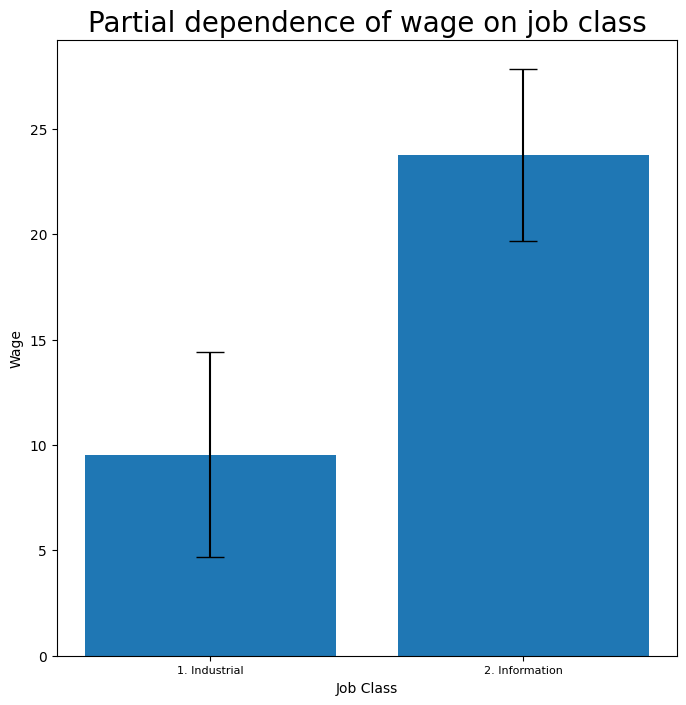

In [29]:
fig, ax = subplots(figsize=(8, 8))
ax = plot_gam(gam_full,1, ax=ax)
ax.set_xlabel('Job Class')
ax.set_ylabel('Wage')
ax.set_title('Partial dependence of wage on job class',
             fontsize=20);
ax.set_xticklabels(Wage['jobclass'].cat.categories, fontsize=8);

In [30]:
gam_full = LinearGAM(s_gam(0) +
                     f_gam(1, lam=0) +
                     f_gam(2, lam=0))
Xgam = np.column_stack([year,
                        Wage['jobclass'].cat.codes,
                        Wage['maritl'].cat.codes])
gam_full = gam_full.fit(Xgam, y)

In [31]:
gam_full.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     11.9952
Link Function:                     IdentityLink Log Likelihood:                                -24791.6961
Number of Samples:                         3000 AIC:                                            49609.3826
                                                AICc:                                           49609.5044
                                                GCV:                                             1559.0922
                                                Scale:                                           1547.8752
                                                Pseudo R-Squared:                                   0.1143
Feature Function                  Lam

/var/folders/cd/7clcx1wj4j9b99700gsd661h0000gn/T/ipykernel_78868/3870570873.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_full.summary()


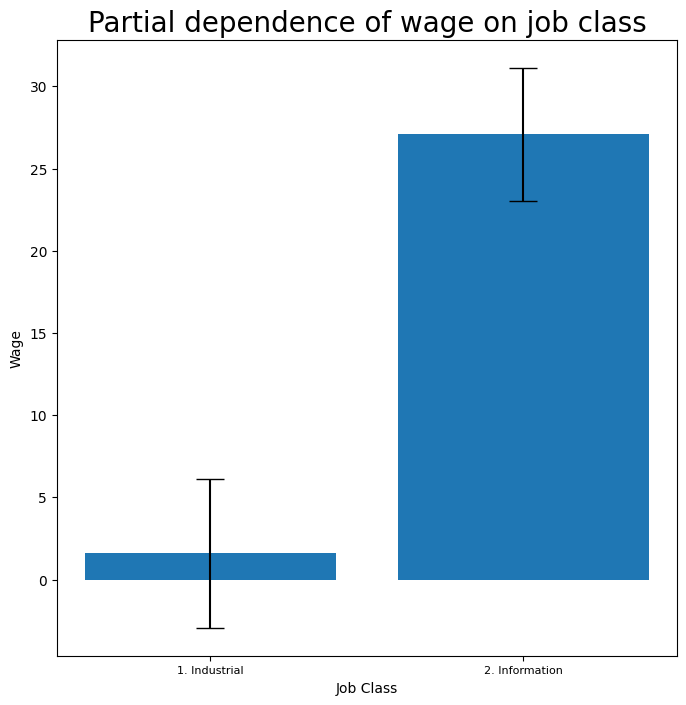

In [32]:
fig, ax = subplots(figsize=(8, 8))
ax = plot_gam(gam_full,1, ax=ax)
ax.set_xlabel('Job Class')
ax.set_ylabel('Wage')
ax.set_title('Partial dependence of wage on job class',
             fontsize=20);
ax.set_xticklabels(Wage['jobclass'].cat.categories, fontsize=8);

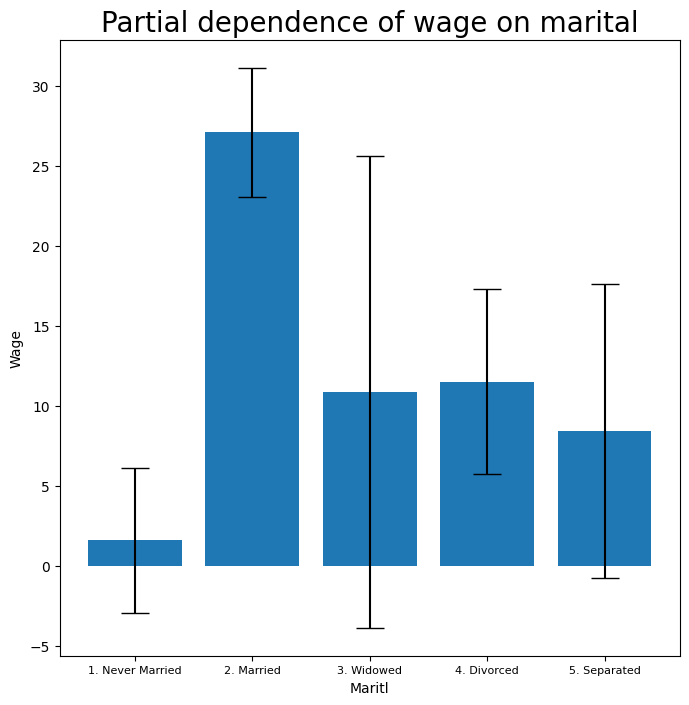

In [33]:
fig, ax = subplots(figsize=(8, 8))
ax = plot_gam(gam_full,2, ax=ax)
ax.set_xlabel('Maritl')
ax.set_ylabel('Wage')
ax.set_title('Partial dependence of wage on marital',
             fontsize=20);
ax.set_xticklabels(Wage['maritl'].cat.categories, fontsize=8);

## Problem 8

Fit some of the non-linear models investigated in this chapter to the Auto data set. Is there evidence for non-linear relationships in this data set? Create some informative plots to justify your answer.

In [34]:
Auto = load_data('Auto')
Auto

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino
...,...,...,...,...,...,...,...,...,...
387,27.0,4,140.0,86,2790,15.6,82,1,ford mustang gl
388,44.0,4,97.0,52,2130,24.6,82,2,vw pickup
389,32.0,4,135.0,84,2295,11.6,82,1,dodge rampage
390,28.0,4,120.0,79,2625,18.6,82,1,ford ranger


In [35]:
mpg= Auto['mpg']
Auto.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           392 non-null    float64
 1   cylinders     392 non-null    int64  
 2   displacement  392 non-null    float64
 3   horsepower    392 non-null    int64  
 4   weight        392 non-null    int64  
 5   acceleration  392 non-null    float64
 6   year          392 non-null    int64  
 7   origin        392 non-null    int64  
 8   name          392 non-null    object 
dtypes: float64(3), int64(5), object(1)
memory usage: 27.7+ KB


In [36]:
Auto['cylinders']=Auto['cylinders'].astype('category')

In [37]:
gam_full = LinearGAM(s_gam(0) +
                     s_gam(1) +
                     f_gam(2, lam=0))
Xgam = np.column_stack([Auto['horsepower'],
                        Auto['weight'],
                        Auto['cylinders'].cat.codes])
y = Auto['mpg']
gam_full = gam_full.fit(Xgam, y)

In [38]:
gam_full.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     26.5687
Link Function:                     IdentityLink Log Likelihood:                                 -1418.6912
Number of Samples:                          392 AIC:                                             2892.5198
                                                AICc:                                            2896.8541
                                                GCV:                                               16.3959
                                                Scale:                                             14.4086
                                                Pseudo R-Squared:                                   0.7789
Feature Function                  Lam

/var/folders/cd/7clcx1wj4j9b99700gsd661h0000gn/T/ipykernel_78868/3870570873.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_full.summary()


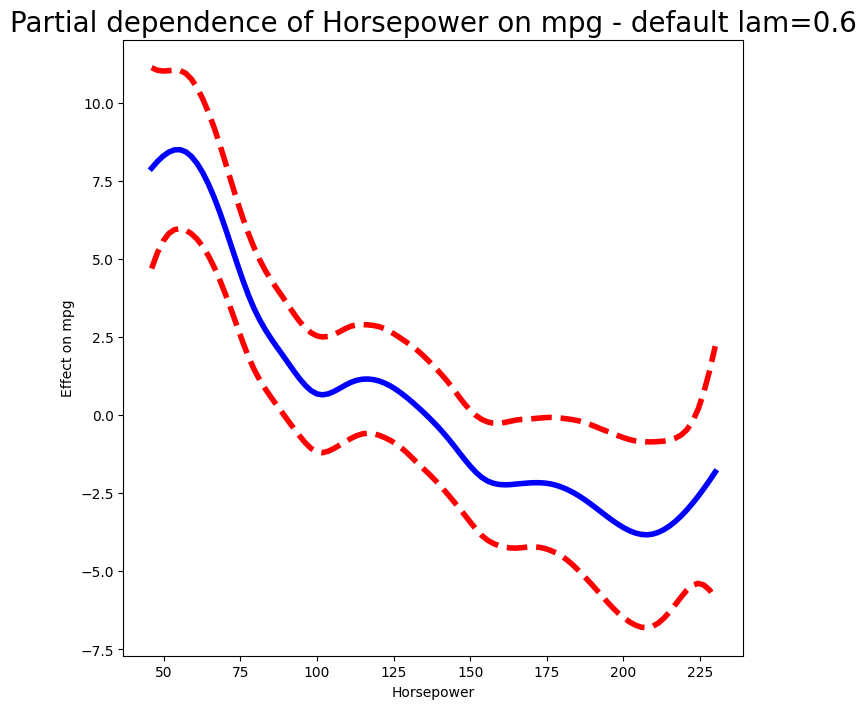

In [39]:
fig, ax = subplots(figsize=(8,8))
plot_gam(gam_full, 0, ax=ax)
ax.set_xlabel('Horsepower')
ax.set_ylabel('Effect on mpg')
ax.set_title('Partial dependence of Horsepower on mpg - default lam=0.6', fontsize=20);

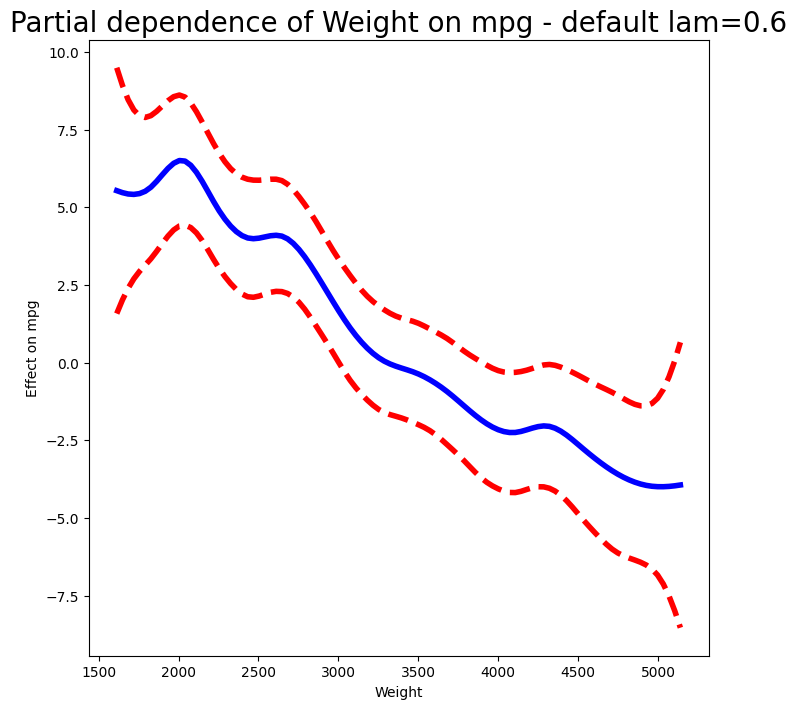

In [40]:
fig, ax = subplots(figsize=(8,8))
plot_gam(gam_full, 1, ax=ax)
ax.set_xlabel('Weight')
ax.set_ylabel('Effect on mpg')
ax.set_title('Partial dependence of Weight on mpg - default lam=0.6', fontsize=20);

In [41]:
Auto['origin']=Auto['origin'].astype('category')

In [42]:
gam_full = LinearGAM(s_gam(0) +
                     s_gam(1) +
                     f_gam(2, lam=0) +
                     f_gam(3, lam=0))
Xgam = np.column_stack([Auto['horsepower'],
                        Auto['weight'],
                        Auto['cylinders'].cat.codes,
                        Auto['origin'].cat.codes])
y = Auto['mpg']
gam_full = gam_full.fit(Xgam, y)

In [43]:
gam_full.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     28.5216
Link Function:                     IdentityLink Log Likelihood:                                 -1403.8068
Number of Samples:                          392 AIC:                                             2866.6568
                                                AICc:                                            2871.6421
                                                GCV:                                               15.9278
                                                Scale:                                             13.8563
                                                Pseudo R-Squared:                                   0.7886
Feature Function                  Lam

/var/folders/cd/7clcx1wj4j9b99700gsd661h0000gn/T/ipykernel_78868/3870570873.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_full.summary()


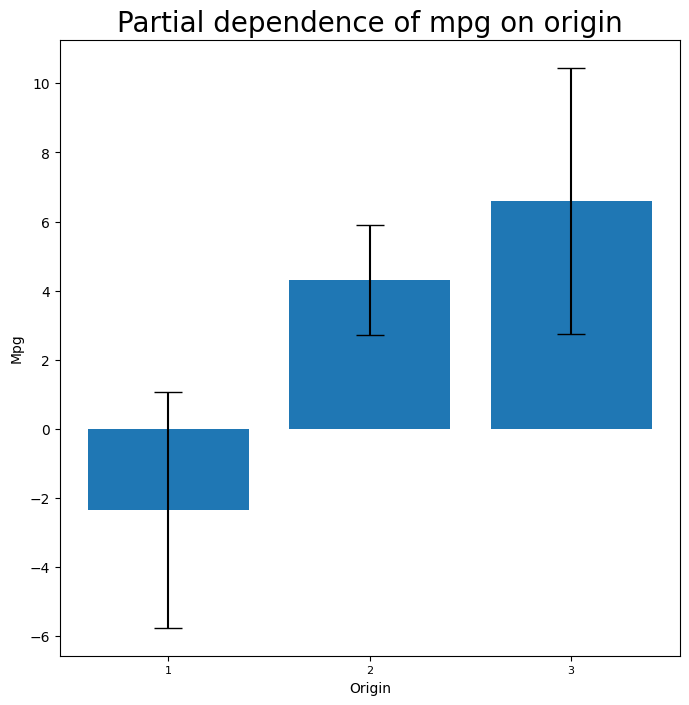

In [44]:
fig, ax = subplots(figsize=(8, 8))
ax = plot_gam(gam_full,3, ax=ax)
ax.set_xlabel('Origin')
ax.set_ylabel('Mpg')
ax.set_title('Partial dependence of mpg on origin',
             fontsize=20);
ax.set_xticklabels(Auto['origin'].cat.categories, fontsize=8);

EXPLORE: Anova for the Auto data to see which variables give evidence for a non-linear relationship and whether there is evidence.

In [45]:
from statsmodels.stats.anova import anova_lm

In [46]:
models = [MS([poly('age', degree=d)]) 
          for d in range(1, 6)]
y=Wage['wage']
Xs = [model.fit_transform(Wage) for model in models]
anova_lm(*[sm.OLS(y, X_).fit()

           for X_ in Xs])

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2998.0,5.022216e+06,0.0,NaN,NaN,NaN
1,2997.0,4.793430e+06,1.0,228786.010128,143.593107,2.363850e-32
2,2996.0,4.777674e+06,1.0,15755.693664,9.888756,1.679202e-03
3,2995.0,4.771604e+06,1.0,6070.152124,3.809813,5.104620e-02
4,2994.0,4.770322e+06,1.0,1282.563017,0.804976,3.696820e-01


In [47]:
y=Auto['mpg']
poly_weight = MS([poly('weight', degree=4)]).fit(Auto)
M = sm.OLS(y, poly_weight.transform(Auto)).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,23.4459,0.211,110.930,0.000
"poly(weight, degree=4)[0]",-128.4436,4.185,-30.694,0.000
"poly(weight, degree=4)[1]",23.1589,4.185,5.534,0.000
"poly(weight, degree=4)[2]",0.2204,4.185,0.053,0.958
"poly(weight, degree=4)[3]",-2.8079,4.185,-0.671,0.503


Degree 2 polynomial for weight.

In [48]:
Auto.describe()

,mpg,displacement,horsepower,weight,acceleration,year
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,23.445918,194.411990,104.469388,2977.584184,15.541327,75.979592
std,7.805007,104.644004,38.491160,849.402560,2.758864,3.683737
min,9.000000,68.000000,46.000000,1613.000000,8.000000,70.000000
25%,17.000000,105.000000,75.000000,2225.250000,13.775000,73.000000
50%,22.750000,151.000000,93.500000,2803.500000,15.500000,76.000000
75%,29.000000,275.750000,126.000000,3614.750000,17.025000,79.000000
max,46.600000,455.000000,230.000000,5140.000000,24.800000,82.000000


In [49]:
y=Auto['mpg']
poly_displacement = MS([poly('displacement', degree=4)]).fit(Auto)
M = sm.OLS(y, poly_displacement.transform(Auto)).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,23.4459,0.221,106.217,0.000
"poly(displacement, degree=4)[0]",-124.2585,4.370,-28.432,0.000
"poly(displacement, degree=4)[1]",31.0895,4.370,7.114,0.000
"poly(displacement, degree=4)[2]",-4.4655,4.370,-1.022,0.308
"poly(displacement, degree=4)[3]",0.7747,4.370,0.177,0.859


In [50]:
y=Auto['mpg']
poly_horsepower = MS([poly('horsepower', degree=4)]).fit(Auto)
M = sm.OLS(y, poly_horsepower.transform(Auto)).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,23.4459,0.221,106.161,0.000
"poly(horsepower, degree=4)[0]",-120.1377,4.373,-27.475,0.000
"poly(horsepower, degree=4)[1]",44.0895,4.373,10.083,0.000
"poly(horsepower, degree=4)[2]",-3.9488,4.373,-0.903,0.367
"poly(horsepower, degree=4)[3]",-5.1878,4.373,-1.186,0.236


<Axes: title={'center': 'Weight Polys'}, xlabel='Weight', ylabel='Auto mpg'>

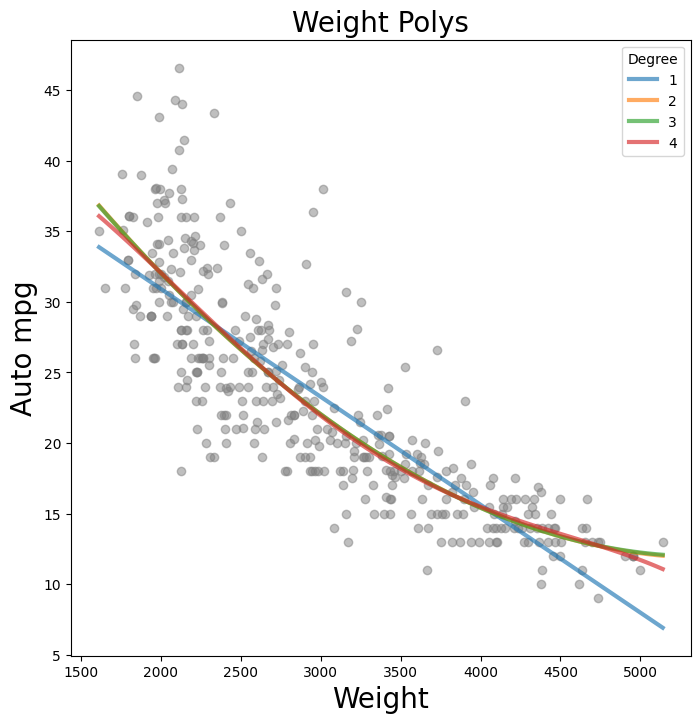

In [51]:
weight = Auto['weight']
weight_grid = np.linspace(weight.min(),
                   weight.max(),
                   100)
weight_df = pd.DataFrame({'weight': weight_grid})

def plot_auto_weight_fit(xvar_df, 
                  title):
    fig, ax = subplots(figsize=(8,8))
    for deg in range(1,5):
        basis = MS([poly('weight', degree=deg)]).fit(Auto)
        X = basis.transform(Auto)
        Xnew = basis.transform(xvar_df)
        M = sm.OLS(y, X).fit()
        preds = M.get_prediction(Xnew)
        ax.plot(xvar_df.values, preds.predicted_mean, label='{:d}'.format(deg), linewidth=3, alpha=0.65)
    ax.scatter(weight,
               y,
               facecolor='gray',
               alpha=0.5)
    ax.set_title(title, fontsize=20)
    ax.set_xlabel('Weight', fontsize=20)
    ax.set_ylabel('Auto mpg', fontsize=20);
    ax.legend(title='Degree');
    return ax

plot_auto_weight_fit(weight_df, 'Weight Polys')

<Axes: title={'center': 'Displacement Polys'}, xlabel='Displacement', ylabel='Auto mpg'>

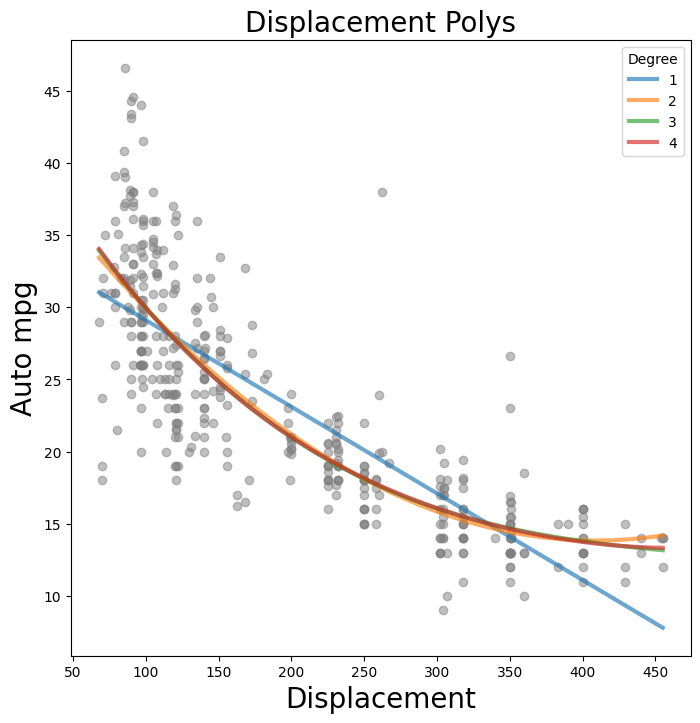

In [52]:
displacement = Auto['displacement']
displacement_grid = np.linspace(displacement.min(),
                   displacement.max(),
                   100)
displacement_df = pd.DataFrame({'displacement': displacement_grid})

def plot_auto_displacement_fit(xvar_df, 
                  title):
    fig, ax = subplots(figsize=(8,8))
    for deg in range(1,5):
        basis = MS([poly('displacement', degree=deg)]).fit(Auto)
        X = basis.transform(Auto)
        Xnew = basis.transform(xvar_df)
        M = sm.OLS(y, X).fit()
        preds = M.get_prediction(Xnew)
        ax.plot(xvar_df.values, preds.predicted_mean, label='{:d}'.format(deg), linewidth=3, alpha=0.65)
    ax.scatter(displacement,
               y,
               facecolor='gray',
               alpha=0.5)
    ax.set_title(title, fontsize=20)
    ax.set_xlabel('Displacement', fontsize=20)
    ax.set_ylabel('Auto mpg', fontsize=20);
    ax.legend(title='Degree');
    return ax

plot_auto_displacement_fit(displacement_df, 'Displacement Polys')

<Axes: title={'center': 'Horsepower Polys'}, xlabel='Horsepower', ylabel='Auto mpg'>

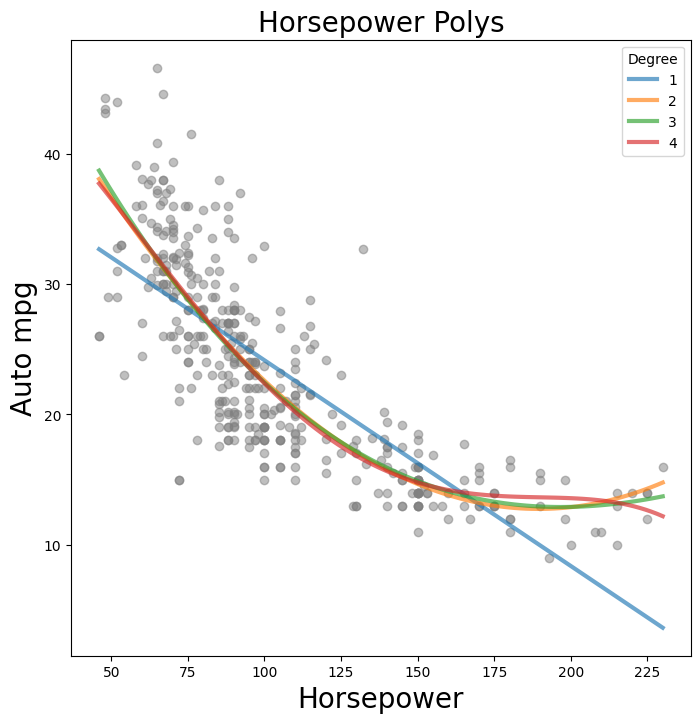

In [53]:
horsepower = Auto['horsepower']
horsepower_grid = np.linspace(horsepower.min(),
                   horsepower.max(),
                   100)
horsepower_df = pd.DataFrame({'horsepower': horsepower_grid})

def plot_auto_horsepower_fit(xvar_df, 
                  title):
    fig, ax = subplots(figsize=(8,8))
    for deg in range(1,5):
        basis = MS([poly('horsepower', degree=deg)]).fit(Auto)
        X = basis.transform(Auto)
        Xnew = basis.transform(xvar_df)
        M = sm.OLS(y, X).fit()
        preds = M.get_prediction(Xnew)
        ax.plot(xvar_df.values, preds.predicted_mean, label='{:d}'.format(deg), linewidth=3, alpha=0.65)
    ax.scatter(horsepower,
               y,
               facecolor='gray',
               alpha=0.5)
    ax.set_title(title, fontsize=20)
    ax.set_xlabel('Horsepower', fontsize=20)
    ax.set_ylabel('Auto mpg', fontsize=20);
    ax.legend(title='Degree');
    return ax

plot_auto_horsepower_fit(horsepower_df, 'Horsepower Polys')

Quadratic seems most relevant for each variable.

## Problem 9

This question uses the variables dis (the weighted mean of distances to five Boston employment centers) and nox (nitrogen oxides concentration in parts per 10 million) from the Boston data. We will treat dis as the predictor and nox as the response.

In [54]:
Boston = load_data('Boston')
Boston

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,6.48,22.0


#### Part (a)

Use the poly() function from the ISLP.models module to fit a cubic polynomial regression to predict nox using dis. Report the regression output, and plot the resulting data and polynomial fits.

<Axes: title={'center': 'Dis Poly'}, xlabel='dis', ylabel='nox'>

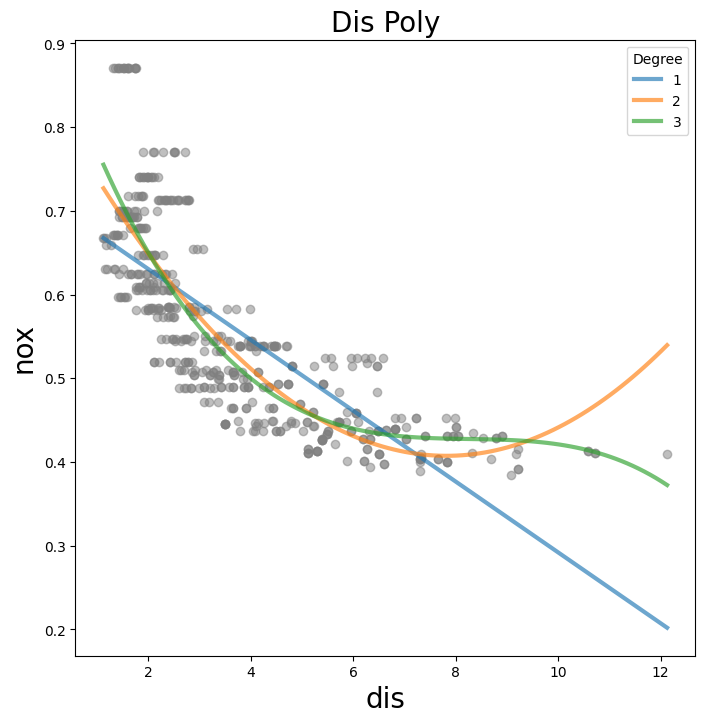

In [55]:
dis = Boston['dis']
y = Boston['nox']
dis_grid = np.linspace(dis.min(),
                   dis.max(),
                   100)
dis_df = pd.DataFrame({'dis': dis_grid})

def plot_auto_dis_fit(xvar_df, 
                  title):
    fig, ax = subplots(figsize=(8,8))
    for deg in range(1,4):
        basis = MS([poly('dis', degree=deg)]).fit(Boston)
        X = basis.transform(Boston)
        Xnew = basis.transform(xvar_df)
        M = sm.OLS(y, X).fit()
        preds = M.get_prediction(Xnew)
        ax.plot(xvar_df.values, preds.predicted_mean, label='{:d}'.format(deg), linewidth=3, alpha=0.65)
    ax.scatter(dis,
               y,
               facecolor='gray',
               alpha=0.5)
    ax.set_title(title, fontsize=20)
    ax.set_xlabel('dis', fontsize=20)
    ax.set_ylabel('nox', fontsize=20);
    ax.legend(title='Degree');
    return ax

plot_auto_dis_fit(dis_df, 'Dis Poly')

In [56]:
import statsmodels.api as sm

In [57]:
basis = MS([poly('dis', degree=4)]).fit(Boston)
M = sm.OLS(y, basis.transform(Boston)).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,0.5547,0.003,200.879,0.000
"poly(dis, degree=4)[0]",-2.0031,0.062,-32.248,0.000
"poly(dis, degree=4)[1]",0.8563,0.062,13.786,0.000
"poly(dis, degree=4)[2]",-0.3180,0.062,-5.120,0.000
"poly(dis, degree=4)[3]",0.0335,0.062,0.540,0.589


#### Part (b)

Plot the polynomial fits for a range of different polynomial degrees (say, from 1 to 10), and report the associated residual sum of squares.

{1: 2.768562858969276,
 2: 2.035261868935257,
 3: 1.9341067071790703,
 4: 1.9329813272985943,
 5: 1.9152899610843042,
 6: 1.8782572985081645,
 7: 1.8494836145829785,
 8: 1.8356296890676882,
 9: 1.8333308044915935,
 10: 1.8321711239313423}

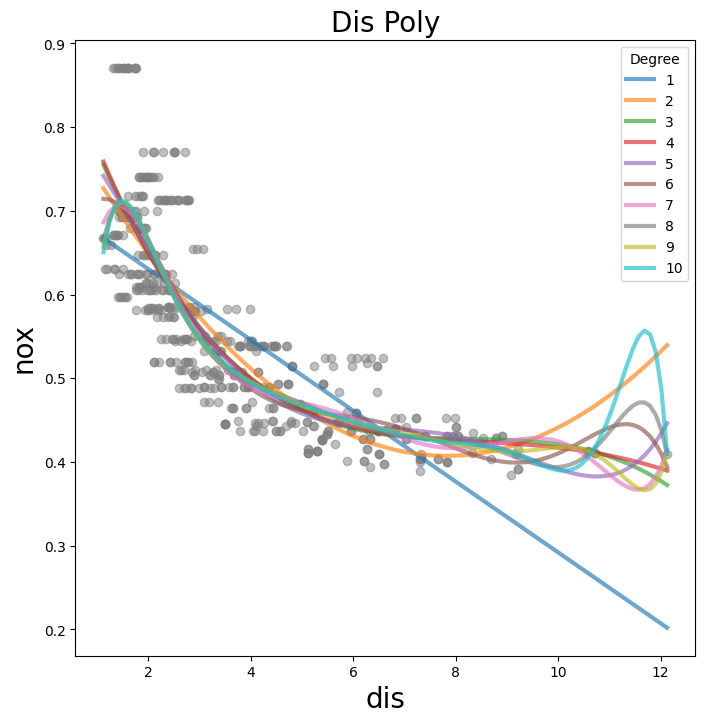

In [58]:
dis = Boston['dis']
dis2_df=pd.DataFrame({'dis':dis})
y = Boston['nox']
dis_grid = np.linspace(dis.min(),
                   dis.max(),
                   100)
dis_df = pd.DataFrame({'dis': dis_grid})

RSS={}

def plot_auto_dis_fit(xvar_df, xvar2_df, 
                  title):
    fig, ax = subplots(figsize=(8,8))
    for deg in range(1,11):
        basis = MS([poly('dis', degree=deg)]).fit(Boston)
        X = basis.transform(Boston)
        Xnew = basis.transform(xvar_df)
        Xnew2 = basis.transform(xvar2_df)
        M = sm.OLS(y, X).fit()
        preds = M.get_prediction(Xnew)
        yhat=M.get_prediction(Xnew2)
        yhat=yhat.predicted_mean
        RSS[deg]=np.sum((y - yhat)**2)
        ax.plot(xvar_df.values, preds.predicted_mean, label='{:d}'.format(deg), linewidth=3, alpha=0.65)
    ax.scatter(dis,
               y,
               facecolor='gray',
               alpha=0.5)
    ax.set_title(title, fontsize=20)
    ax.set_xlabel('dis', fontsize=20)
    ax.set_ylabel('nox', fontsize=20);
    ax.legend(title='Degree');
    return ax

plot_auto_dis_fit(dis_df, dis2_df, 'Dis Poly')
RSS

The residual sum of squares also seems to suggest the degree 2 or degree 3 polynomials are more significant than jumping to higher degrees.

#### Part (c)

Perform cross-validation or another approach to select the optimal degree for the polynomial, and explain your results.

In [59]:
cv_error = np.zeros(10)
H = np.array(dis)
M = sklearn_sm(sm.OLS)
#Let's introduce splits. We choose 5-folds cross validation for this example
cv = KFold(n_splits=5,shuffle=True,random_state=0) # The argument shuffle allows samples to overlap
for i, d in enumerate(range(1,11)):
    Xcross = np.power.outer(H, np.arange(d+1))
    M_CV = cross_validate(M,Xcross,y,cv=cv)
    cv_error[i] = np.mean(M_CV['test_score'])
cv_error

array([0.00550455, 0.00404589, 0.00384482, 0.00385288, 0.00405327,
       0.00490166, 0.00711742, 0.0065405 , 0.02188365, 0.00468504])

Cross validation also suggests the degree 3 polynomial is the best.

#### Part (d)

Use the bs() function from the ISLP.models module to fit a regression spline to predict nox using dis. Report the output for the fit using four degrees of freedom. How did you choose the knots? Plot the resulting fit.

In [60]:
from ISLP.models import bs

In [61]:
bs_dis = MS([bs('dis', df=4)]).fit(Boston)
M_bs = sm.OLS(y, bs_dis.transform(Boston)).fit()
summarize(M_bs)

,coef,std err,t,P>|t|
intercept,0.7345,0.015,50.306,0.000
"bs(dis, df=4)[0]",-0.0581,0.022,-2.658,0.008
"bs(dis, df=4)[1]",-0.4636,0.024,-19.596,0.000
"bs(dis, df=4)[2]",-0.1998,0.043,-4.634,0.000
"bs(dis, df=4)[3]",-0.3888,0.046,-8.544,0.000


In [62]:
bs_dis.features_

{'crim': Feature(variables=('crim',), name='crim', encoder=None, use_transform=True, pure_columns=True, override_encoder_colnames=False),
 'zn': Feature(variables=('zn',), name='zn', encoder=None, use_transform=True, pure_columns=True, override_encoder_colnames=False),
 'indus': Feature(variables=('indus',), name='indus', encoder=None, use_transform=True, pure_columns=True, override_encoder_colnames=False),
 'chas': Feature(variables=('chas',), name='chas', encoder=None, use_transform=True, pure_columns=True, override_encoder_colnames=False),
 'nox': Feature(variables=('nox',), name='nox', encoder=None, use_transform=True, pure_columns=True, override_encoder_colnames=False),
 'rm': Feature(variables=('rm',), name='rm', encoder=None, use_transform=True, pure_columns=True, override_encoder_colnames=False),
 'age': Feature(variables=('age',), name='age', encoder=None, use_transform=True, pure_columns=True, override_encoder_colnames=False),
 'dis': Feature(variables=('dis',), name='dis', e

Here we examine the knots that are automatically chosen:

In [63]:
Q1 = Boston['dis'].quantile(0.25)
Q2 = Boston['dis'].quantile(0.50) # Also the median
Q3 = Boston['dis'].quantile(0.75)
Q1, Q2, Q3

(2.100175, 3.2074499999999997, 5.1884250000000005)

Next we plot this resulting fit.

Text(0, 0.5, 'nox')

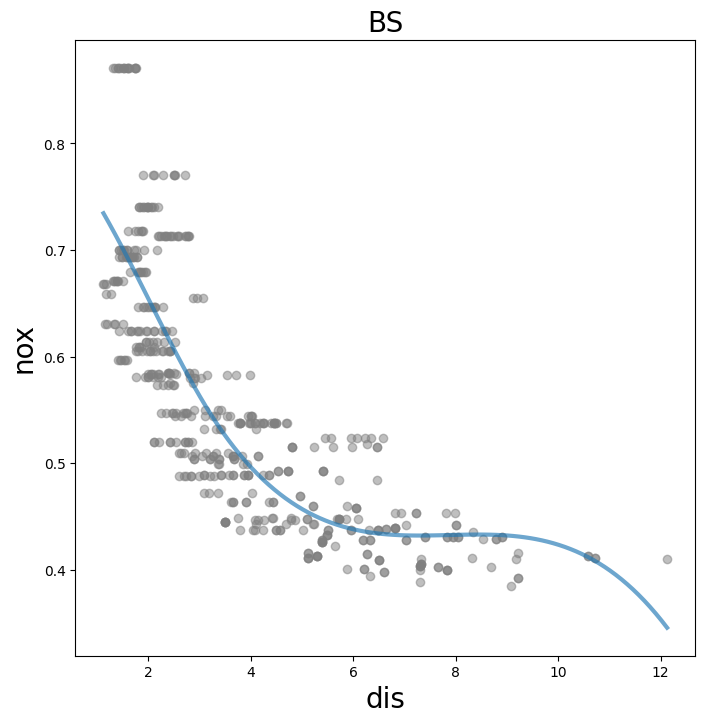

In [64]:
dis = Boston['dis']
y = Boston['nox']
dis_grid = np.linspace(dis.min(),
                   dis.max(),
                   100)
dis_df = pd.DataFrame({'dis': dis_grid})

fig, ax = subplots(figsize=(8,8))

X = bs_dis.transform(Boston)
Xnew = bs_dis.transform(dis_df)
preds = M_bs.get_prediction(Xnew)
ax.plot(dis_df.values, preds.predicted_mean, linewidth=3, alpha=0.65)
ax.scatter(dis,
               y,
               facecolor='gray',
               alpha=0.5)
ax.set_title('BS', fontsize=20)
ax.set_xlabel('dis', fontsize=20)
ax.set_ylabel('nox', fontsize=20)

We finished this part.

#### Part (e)

Now fit a regression spline for a range of degrees of freedom, and plot the resulting fits and report the resulting RSS. Describe the results obtained.

In [65]:
bs_dis = MS([bs('dis', df=5)]).fit(Boston)
M_bs = sm.OLS(y, bs_dis.transform(Boston)).fit()
summarize(M_bs)

,coef,std err,t,P>|t|
intercept,0.6725,0.020,33.699,0.000
"bs(dis, df=5)[0]",0.0831,0.029,2.891,0.004
"bs(dis, df=5)[1]",-0.1346,0.020,-6.782,0.000
"bs(dis, df=5)[2]",-0.2551,0.035,-7.336,0.000
"bs(dis, df=5)[3]",-0.2678,0.041,-6.599,0.000
"bs(dis, df=5)[4]",-0.2610,0.052,-5.007,0.000


In [72]:
RSS_spline = {}

for df in range(3, 11):
    bs_dis = MS([bs('dis', df=df)]).fit(Boston)
    M_bs = sm.OLS(y, bs_dis.transform(Boston)).fit()
    Xnew = bs_dis.transform(dis_df)
    preds = M_bs.get_prediction(Xnew)
    yhat = M_bs.predict(bs_dis.transform(Boston))
    RSS_spline[df] = np.sum((y - yhat) ** 2)

RSS_spline

{3: 1.9341067071790707,
 4: 1.9227749928119253,
 5: 1.8401728014885235,
 6: 1.8339659031602094,
 7: 1.829884445923284,
 8: 1.8169950567252333,
 9: 1.825652510387056,
 10: 1.7925348895561335}

There is a significant drop in the RSS with 5 degrees of freedom, but more degrees of freedom seems unnecessary perhaps.

Text(0, 0.5, 'nox')

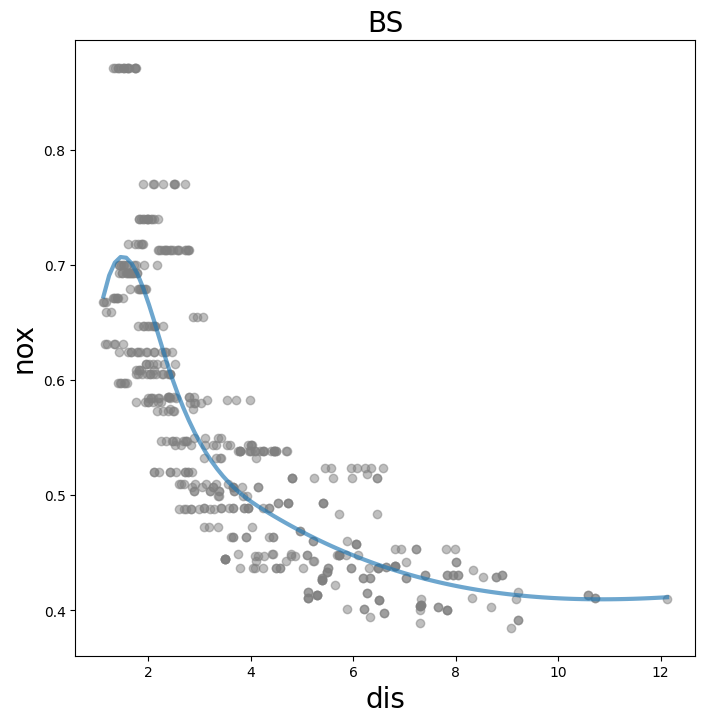

In [66]:
dis = Boston['dis']
y = Boston['nox']
dis_grid = np.linspace(dis.min(),
                   dis.max(),
                   100)
dis_df = pd.DataFrame({'dis': dis_grid})

fig, ax = subplots(figsize=(8,8))

X = bs_dis.transform(Boston)
Xnew = bs_dis.transform(dis_df)
preds = M_bs.get_prediction(Xnew)
ax.plot(dis_df.values, preds.predicted_mean, linewidth=3, alpha=0.65)
ax.scatter(dis,
               y,
               facecolor='gray',
               alpha=0.5)
ax.set_title('BS', fontsize=20)
ax.set_xlabel('dis', fontsize=20)
ax.set_ylabel('nox', fontsize=20)

In [67]:
# Calculate the residuals
residuals = y - M_bs.fittedvalues

# Compute the RSS
RSS_model = np.sum(residuals**2)
RSS_model

1.8401728014885235

This seems like it might be overfitting for weighted distances below 2.

#### Part (f)

Perform cross-validation or another approach in order to select the best degrees of freedom for a regression spline on this data. Describe your results.

In [71]:
cv_error = {}

for df in range(3, 11):
    bs_dis = MS([bs('dis', df=df)]).fit(Boston)
    X = bs_dis.transform(Boston)
    cv = KFold(n_splits=5, shuffle=True, random_state=0)
    M = sklearn_sm(sm.OLS)
    M_CV = cross_validate(M, X, y, cv=cv)
    cv_error[df] = np.mean(M_CV['test_score'])

cv_error

{3: 0.0038448186268742928,
 4: 0.003843289954681395,
 5: 0.0037074610621988064,
 6: 0.0036934234389700616,
 7: 0.0036883029513828077,
 8: 0.0036905501374796144,
 9: 0.003742055943537881,
 10: 0.0036956112660600205}

There's not much change here either after 5 degrees of freedom.
5 degrees of freedom seems like a good choice.

## Problem 10

This question relates to the College data set.

In [74]:
college = load_data('College')
college

,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
0,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
1,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
2,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
3,Yes,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
4,Yes,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
772,No,2197,1515,543,4,26,3089,2029,6797,3900,500,1200,60,60,21.0,14,4469,40
773,Yes,1959,1805,695,24,47,2849,1107,11520,4960,600,1250,73,75,13.3,31,9189,83
774,Yes,2097,1915,695,34,61,2793,166,6900,4200,617,781,67,75,14.4,20,8323,49
775,Yes,10705,2453,1317,95,99,5217,83,19840,6510,630,2115,96,96,5.8,49,40386,99


In [ ]:
college['Private'] = college['Private'].apply(lambda x: 1 if x == 'Yes' else 0)


In [81]:
college.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 777 entries, 0 to 776
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Private      777 non-null    int64  
 1   Apps         777 non-null    int64  
 2   Accept       777 non-null    int64  
 3   Enroll       777 non-null    int64  
 4   Top10perc    777 non-null    int64  
 5   Top25perc    777 non-null    int64  
 6   F.Undergrad  777 non-null    int64  
 7   P.Undergrad  777 non-null    int64  
 8   Outstate     777 non-null    int64  
 9   Room.Board   777 non-null    int64  
 10  Books        777 non-null    int64  
 11  Personal     777 non-null    int64  
 12  PhD          777 non-null    int64  
 13  Terminal     777 non-null    int64  
 14  S.F.Ratio    777 non-null    float64
 15  perc.alumni  777 non-null    int64  
 16  Expend       777 non-null    int64  
 17  Grad.Rate    777 non-null    int64  
dtypes: float64(1), int64(17)
memory usage: 109.4 KB


#### Part (a)

Split the data into a training set and a test set. Using out-of-state tuition as the response and the other variables as the predictors, perform forward stepwise selection on the training set in order to identify a satisfactory model that uses just a subset of the predictors.

In [83]:
college_train,college_test = skm.train_test_split(college,
                                                 test_size=0.5,
                                                 random_state=0)

In [84]:
def nCp(sigma2, estimator, X, Y):
    "Negative Cp statistic"
    n, p = X.shape
    Yhat = estimator.predict(X)
    RSS = np.sum((Y - Yhat)**2)
    return -(RSS + 2 * p * sigma2) / n

In [85]:
from statsmodels.api import OLS

In [86]:
design = MS(college_train.columns.drop('Outstate')).fit(college_train)
Y = np.array(college_train['Outstate'])
X = design.transform(college_train)
sigma2 = OLS(Y,X).fit().scale

In [87]:
from functools import partial

In [88]:
from ISLP.models import \
     (Stepwise,
      sklearn_selected,
      sklearn_selection_path)

In [89]:
neg_Cp = partial(nCp, sigma2)

In [90]:
strategy = Stepwise.first_peak(design,
                               direction='forward',
                               max_terms=len(design.terms))

In [91]:
college_MSE = sklearn_selected(OLS,
                               strategy, scoring=neg_Cp)
college_MSE.fit(college_train, Y)
college_MSE.selected_state_

('Accept',
 'Expend',
 'F.Undergrad',
 'Grad.Rate',
 'Personal',
 'Private',
 'Room.Board',
 'Terminal',
 'Top10perc',
 'perc.alumni')

We have narrowed down to 10 predictors.

We finished this part and can start on part b.

#### Part (b)

Fit a GAM on the training data, using out-of-state tuition as the response and the features selected in the previous step as the predictors. Plot the results, and explain your findings.

#### Part (c)

Evaluate the model obtained on the test set, and explain the results obtained.

#### Part (d)

For which variables, if any, is there evidence of a non-linear relationship with the response?

## Problem 11

### In Section 7.7, it was mentioned that GAMs are generally fit using a backfitting approach. 
### The idea behind backfitting is actually quite simple. We will now explore backfitting in the context of multiple linear regression.

Suppose that we would like to perform multiple linear regression, but we do not have software to do so. Instead, we only have software to perform simple linear regression. Therefore, we take the following iterative approach: we repeatedly hold all but one coefficient estimate fixed at its current value, and update only that coefficient estimate using a simple linear regression. The process is continued until convergence—that is, until the coefficient estimates stop changing.

We now try this out on a toy example.

#### Part (a)

Generate a response $Y$ and two predictors $X_1$ and $X_2$, with
$n = 100$.

#### Part (b)

Write a function simple_reg() that takes two arguments outcome and feature, fits a simple linear regression model with this outcome and feature, and returns the estimated intercept and slope.

#### Part (c)

Initialize beta1 to take on a value of your choice. It does not
matter what value you choose.

#### Part (d)

Keeping beta1 fixed, use your function simple_reg() to fit the model:
$$Y− beta1· X_1 = β_0 + β_2X_2 + ϵ.$$
Store the resulting values as beta0 and beta2.

#### Part (e)

Keeping beta2 fixed, fit the model
$$Y− beta2· X_2 = β_0 + β_1X_1 + ϵ.$$
Store the result as beta0 and beta1 (overwriting their previous
values).

#### Part(f)

Write a for loop to repeat (c) and (d) 1,000 times. Report the
estimates of beta0, beta1, and beta2 at each iteration of the for
loop. Create a plot in which each of these values is displayed,
with beta0, beta1, and beta2.

#### Part (g)

Compare your answer in (e) to the results of simply performing multiple linear regression to predict $Y$ using $X_1$ and $X_2$.
Use axline() method to overlay those multiple linear regression coefficient estimates on the plot obtained in (e).

#### Part (h)

On this data set, how many backfitting iterations were required in order to obtain a “good” approximation to the multiple regression coefficient estimates?

## Problem 12

This problem is a continuation of the previous exercise. In a toy
example with p = 100, show that one can approximate the multiple
linear regression coefficient estimates by repeatedly performing simple
linear regression in a backfitting procedure. How many backfitting
iterations are required in order to obtain a “good” approximation to
the multiple regression coefficient estimates? Create a plot to justify
your answer.